# Learning curve analysis

Yangkang Chen<br>
Jan 12, 2024

This notebook is to show the advantages of `AdaSTEM` framework compared to naive bulk modeling method.

The task we explore here will be the same as [AdaSTEM demo](https://chenyangkang.github.io/stemflow/Examples/01.AdaSTEM_demo.html): Predict the abundance of [Mallard](https://en.wikipedia.org/wiki/Mallard) (a bird species) based on environmental variables. The data were requested from [eBird](https://ebird.org/home), a citizen science project for bird observation, and with some variable annotation.


In [ ]:
import pandas as pd
import numpy as np
import random
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib
import warnings
import pickle
import os

from stemflow.model.AdaSTEM import AdaSTEM, AdaSTEMClassifier, AdaSTEMRegressor
from xgboost import XGBClassifier, XGBRegressor
from stemflow.model.Hurdle import Hurdle_for_AdaSTEM, Hurdle
from stemflow.model_selection import ST_CV

warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

Please download the sample data from:<br>
- Mallard: https://figshare.com/articles/dataset/Sample_data_Mallard_csv/24080745<br>

Suppose now it's downloaded and saved as './Sample_data_Mallard.csv'<br>

Alternatively, you can try other species like <br>
- Alder Flycatcher: https://figshare.com/articles/dataset/Sample_data_Alder_Flycatcher_csv/24080751<br>
- Short-eared Owl: https://figshare.com/articles/dataset/Sample_data_Short-eared_Owl_csv/24080742<br>
- Eurasian Tree Sparrow: https://figshare.com/articles/dataset/Sample_data_Eurasian_Tree_Sparrow_csv/24080748<br>

**Caveat: These bird observation data are about 200MB each file.**

## Load data

In [4]:
data = pd.read_csv(f'./Sample_data_Mallard.csv')
data = data.drop('sampling_event_identifier', axis=1)

## Determine the gradient of learning curve analysis

In [5]:
volume_list = [10000, 50000, 100000, 200000, 400000]

## Learning curve analysis

In the following section, we explore the model performance of `AdaSTEM model `and `naive hurdle model`, both with the same base model – XGB. 

We compare the model performance in terms of different data volume input: `10000, 50000, 100000, 200000 and 400000` samples.

Metrics are calculated for both classification `('AUC', 'kappa', 'f1', 'precision', 'recall', 'average_precision')` and regression `('Spearman_r', 'Pearson_r', 'R2', 'MAE', 'MSE', 'poisson_deviance_explained')`.



In [7]:
def get_X_and_y(data):
    X = data.drop('count', axis=1)
    y = data['count'].values
    return X, y

In [8]:
all_metric_list = []

for volume in volume_list:
    if volume == 400000:
        tmp_data = data
    else:
        tmp_data = data.sample(volume, replace=False)
        
    # Get X and y
    X, y = get_X_and_y(tmp_data)
    
    # First thing first: Spatio-temporal train test split
    CV_generator = ST_CV(X, y,
                            Spatio_blocks_count = 50, Temporal_blocks_count=50,
                            CV=5)

    for cv_count, (X_train, X_test, y_train, y_test) in enumerate(CV_generator):
        # 1. Train AdaSTEM hurdle model
        model = AdaSTEMRegressor(
            base_model=Hurdle(
                classifier=XGBClassifier(tree_method='hist',random_state=42, verbosity = 0, n_jobs=1),
                regressor=XGBRegressor(tree_method='hist',random_state=42, verbosity = 0, n_jobs=1)
            ),
            save_gridding_plot = True,
            ensemble_fold=10, 
            min_ensemble_required=7,
            grid_len_upper_threshold=25,
            grid_len_lower_threshold=5,
            points_lower_threshold=50,
            Spatio1='longitude',
            Spatio2 = 'latitude', 
            Temporal1 = 'DOY',
            use_temporal_to_train=True,
            n_jobs=1                       
        )

        ## fit adastem
        model.fit(X_train.reset_index(drop=True), y_train, verbosity=0)
        
        # Evaluation
        pred_adastem = model.predict(X_test, verbosity=0)
        perc = np.sum(np.isnan(pred_adastem.flatten()))/len(pred_adastem.flatten())
        print(f'Data volume {volume}, CV {cv_count}: AdaSTEM percentage not predictable {round(perc*100, 2)}%')

        # 2. Compare to simple Hurdle model
        model_SH = Hurdle(classifier=XGBClassifier(tree_method='hist',random_state=42, verbosity = 0, n_jobs=1),
                regressor=XGBRegressor(tree_method='hist',random_state=42, verbosity = 0, n_jobs=1))
        model_SH.fit(X_train[[i for i in X_train.columns if not i in ['longitude','latitude']]], y_train)
        pred_SH = model_SH.predict(X_test[[i for i in X_train.columns if not i in ['longitude','latitude']]])
        
        # 3. save metrics
        pred_df = pd.DataFrame({
            'y_true':y_test.flatten(),
            'y_pred_adastem':np.where(pred_adastem.flatten()<0, 0, pred_adastem.flatten()),
            'y_pred_SH':np.where(np.array(pred_SH).flatten()<0, 0, np.array(pred_SH).flatten())
        }).dropna() # to make sure that all points are both predicatble by adastem and simple hurdle model
        
        ## 3.1 adastem metrics
        metric_dict = AdaSTEM.eval_STEM_res('hurdle', pred_df.y_true, pred_df.y_pred_adastem)
        metric_dict['X_train_size'] = X_train.shape[0]
        metric_dict['CV'] = cv_count
        metric_dict['perc_not_predictable'] = perc
        metric_dict['model'] = 'AdaSTEM'
        metric_dict['Train_test_data_volume'] = volume
        all_metric_list.append(metric_dict.copy())
        
        ## 3.2 simple hurdle metrics
        metric_dict = AdaSTEM.eval_STEM_res('hurdle', np.array(pred_df.y_true).flatten(), 
                                            np.where(
                                                np.array(pred_df.y_pred_SH).flatten()<0,
                                                0,
                                                np.array(pred_df.y_pred_SH).flatten()
                                                )
                                            )
        metric_dict['X_train_size'] = X_train.shape[0]
        metric_dict['CV'] = cv_count
        metric_dict['perc_not_predictable'] = np.nan
        metric_dict['model'] = 'XGBoostHurdle'
        metric_dict['Train_test_data_volume'] = volume
        all_metric_list.append(metric_dict.copy())
        
    
    

Data volume 10000, CV 0: AdaSTEM percentage not predictable 38.96%
Data volume 10000, CV 1: AdaSTEM percentage not predictable 38.47%
Data volume 10000, CV 2: AdaSTEM percentage not predictable 43.53%
Data volume 10000, CV 3: AdaSTEM percentage not predictable 44.23%
Data volume 10000, CV 4: AdaSTEM percentage not predictable 35.58%
Data volume 50000, CV 0: AdaSTEM percentage not predictable 15.26%
Data volume 50000, CV 1: AdaSTEM percentage not predictable 13.64%
Data volume 50000, CV 2: AdaSTEM percentage not predictable 15.53%
Data volume 50000, CV 3: AdaSTEM percentage not predictable 16.17%
Data volume 50000, CV 4: AdaSTEM percentage not predictable 14.52%
Data volume 100000, CV 0: AdaSTEM percentage not predictable 8.9%
Data volume 100000, CV 1: AdaSTEM percentage not predictable 8.69%
Data volume 100000, CV 2: AdaSTEM percentage not predictable 8.78%
Data volume 100000, CV 3: AdaSTEM percentage not predictable 9.14%
Data volume 100000, CV 4: AdaSTEM percentage not predictable 8.

We see that as data volume increases, the model covers larger space and time, and is increasingly capable of predicting more spatiotemporal units.

In [9]:
all_metric_df = pd.DataFrame(all_metric_list)
all_metric_df.to_csv('./Learning_curve.csv',index=False)

We save the metrics for plotting.

## Plot learning curve metrics

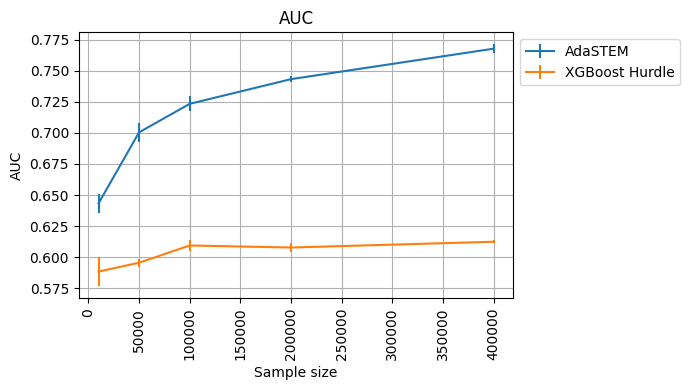

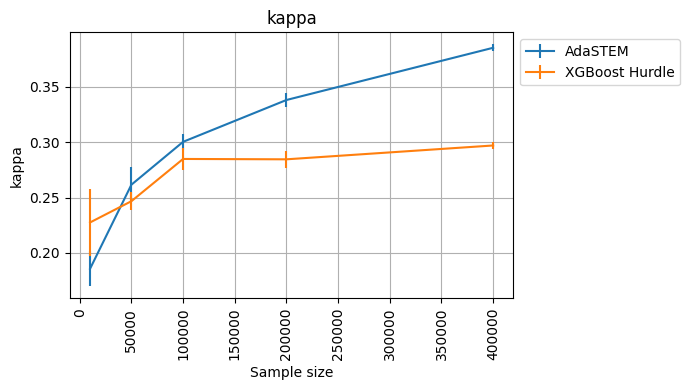

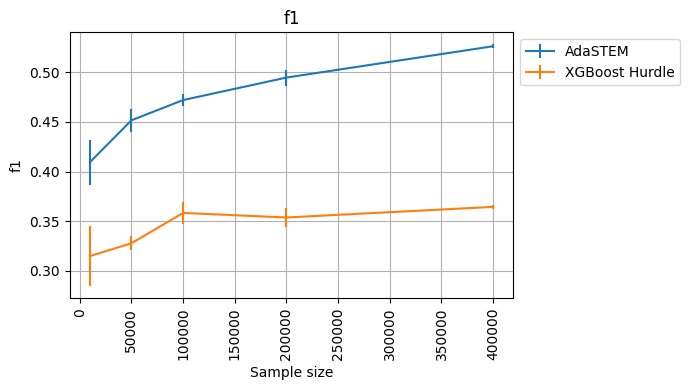

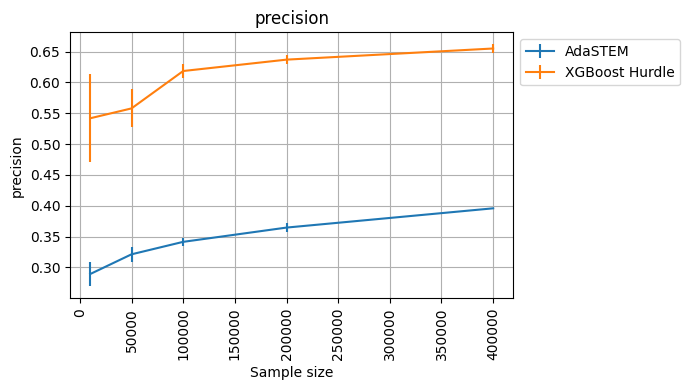

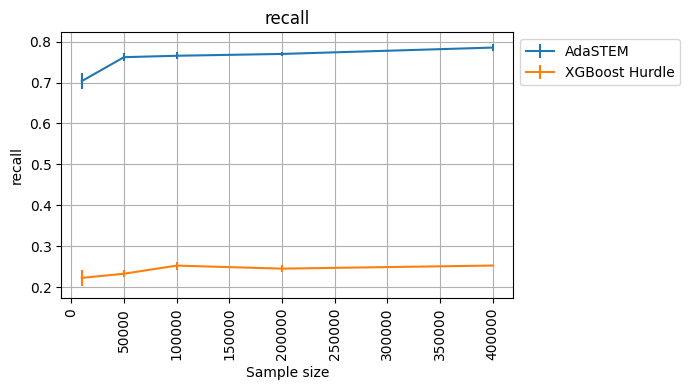

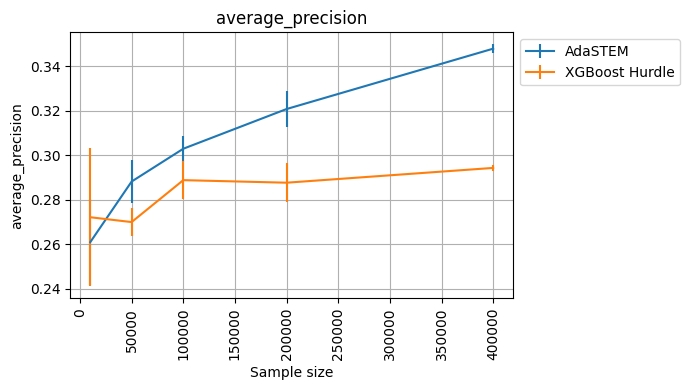

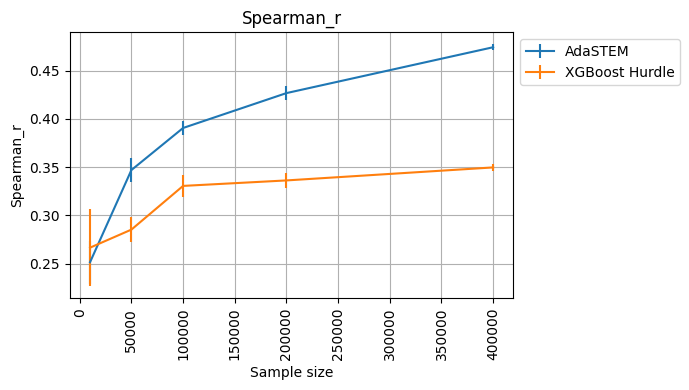

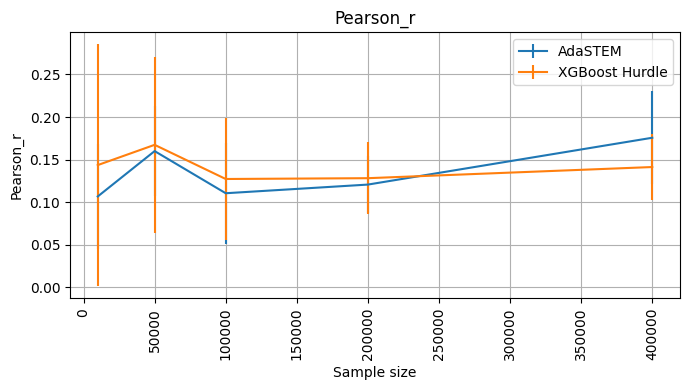

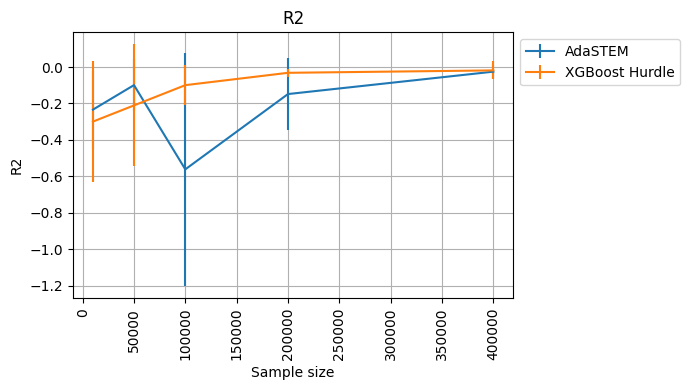

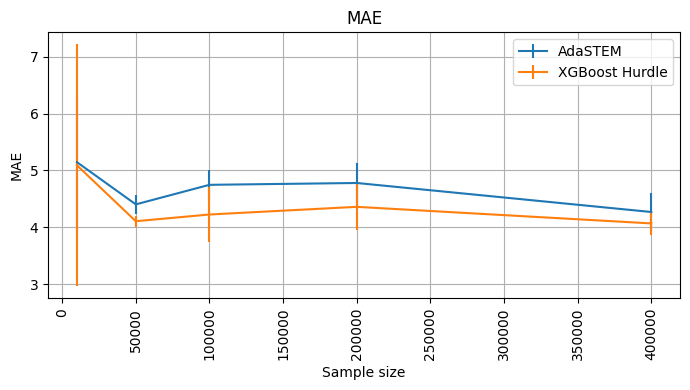

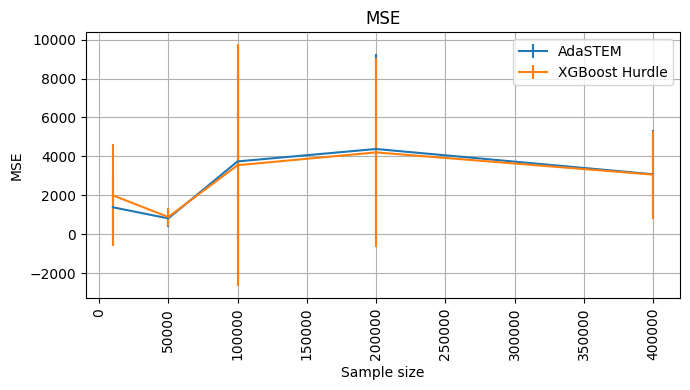

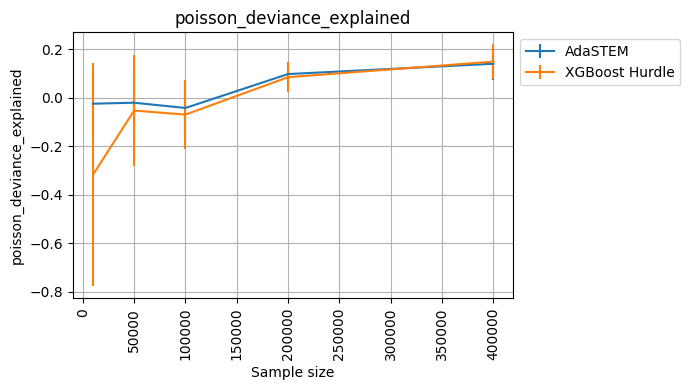

In [10]:
for var_ in ['AUC', 'kappa', 'f1', 'precision', 'recall', 'average_precision',
       'Spearman_r', 'Pearson_r', 'R2', 'MAE', 'MSE',
       'poisson_deviance_explained']:
    plt.figure(figsize=(7,4))
    
    sub = all_metric_df[all_metric_df.model=='AdaSTEM']
    plt.errorbar(
        x=sub.groupby('Train_test_data_volume').first().index,
        y=sub.groupby('Train_test_data_volume')[var_].mean(),
        yerr=sub.groupby('Train_test_data_volume')[var_].std(),
        label = 'AdaSTEM'
    )

    sub = all_metric_df[all_metric_df.model=='XGBoostHurdle']
    plt.errorbar(
        x=sub.groupby('Train_test_data_volume').first().index,
        y=sub.groupby('Train_test_data_volume')[var_].mean(),
        yerr=sub.groupby('Train_test_data_volume')[var_].std(),
        label='XGBoost Hurdle'
    )

    plt.legend(bbox_to_anchor=(1,1))
    plt.grid()
    plt.title(var_)
    plt.xlabel('Sample size')
    plt.ylabel(f'{var_}')
    plt.xticks(rotation=90)
        
    plt.tight_layout()
    plt.savefig(f'./comparing_AdaSTEM_and_Hurdle_{var_}.pdf')
    plt.show()



## Conclusion


- classification tasks:
  - AdaSTEM shows significant superiority in most metrics. Except for one: it has lower precision than naive hurdle model.
  - As the data volume increase, the superiority is increasingly magnified.
  - For small sample size (e.g., 10000), AdaSTEM may not have better performance and could be worse than naive models.

- Regression tasks:
  - We did not observed significant difference between the two modeling framework.
  - However, as the data volume keeps increasing, we would expect some superiority of AdaSTEM based on my experience.

  
  

In [11]:
from watermark import watermark
print(watermark())
print(watermark(packages="stemflow,numpy,scipy,pandas,xgboost,tqdm,matplotlib,h3pandas,geopandas,scikit-learn"))


Last updated: 2023-09-19T18:52:18.085744+08:00

Python implementation: CPython
Python version       : 3.9.7
IPython version      : 8.14.0

Compiler    : Clang 11.1.0 
OS          : Darwin
Release     : 21.6.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

stemflow    : 0.0.24
numpy       : 1.24.3
scipy       : 1.10.1
pandas      : 2.0.3
xgboost     : 1.7.6
tqdm        : 4.65.0
matplotlib  : 3.7.1
h3pandas    : 0.2.4
geopandas   : 0.11.1
scikit-learn: 0.0

